In [1]:
import pandas as pd
import xgboost as xgb
from xgboost import *
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, make_scorer, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import KFold, train_test_split, cross_validate, RepeatedStratifiedKFold, GridSearchCV, cross_val_score
import numpy as np
from imblearn.combine import SMOTETomek, SMOTEENN
from collections import Counter
from imblearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
import seaborn as sns
import sys
sys.path.append('/Users/ayoucruz/Desktop/Data_Science/3nd_Semester/DATA7901 Capstone project/Capstone/Models/Functions')
from Evaluation import *
from Preparation import *
import pickle

In [2]:
X, y, data = preparation_class_threshold()

/Users/ayoucruz/Desktop/Data_Science/3nd_Semester/DATA7901 Capstone project/Capstone/Models/Functions/Preparation.py:717: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df_location = pd.read_csv('../../Dataset/Location.csv')


In [3]:
smoteenn_model = pickle.load(open("Saved_models_remove/xgb_smote.pkl", 'rb'))
# shap_values = pickle.load(open("shapanalysis/shap_values_remove.pkl", 'rb'))

In [4]:
xgb_classifier = smoteenn_model.named_steps['xgbclassifier']
pipeline_smote = make_imb_pipeline(SMOTE(random_state=42), XGBClassifier(n_jobs=-1))
pipeline_smoteen = make_imb_pipeline(SMOTEENN(random_state=42), XGBClassifier(n_jobs=-1))
pipeline_tomek = make_imb_pipeline(SMOTETomek(random_state=42), XGBClassifier(n_jobs=-1))
pipeline_under = make_imb_pipeline(RandomUnderSampler(random_state=42), XGBClassifier(n_jobs=-1))

feature_importances = xgb_classifier.feature_importances_
features_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})
features_df = features_df.sort_values(by='Importance', ascending=False)
top_20_features = features_df.head(20)
top_30_features = features_df.head(30)
top_40_features = features_df.head(40)
top_50_features = features_df.head(50)

In [5]:
weather_features = ['Crash_Road_Surface_Condition_Sealed - Dry','Crash_Road_Surface_Condition_Sealed - Wet', 
                    'Crash_Road_Surface_Condition_Unsealed - Dry','Crash_Road_Surface_Condition_Unsealed - Wet', 
                    'Crash_Atmospheric_Condition_Clear', 'Crash_Atmospheric_Condition_Fog','Crash_Atmospheric_Condition_Raining',
                    'Crash_Atmospheric_Condition_Smoke/Dust', 'Crash_Lighting_Condition_Darkness - Lighted',
                    'Crash_Lighting_Condition_Darkness - Not lighted','Crash_Lighting_Condition_Dawn/Dusk','Crash_Lighting_Condition_Daylight',
                    'Crash_Road_Horiz_Align_Curved - view obscured','Crash_Road_Horiz_Align_Curved - view open','Crash_Road_Horiz_Align_Straight', 
                    'Crash_Road_Vert_Align_Crest', 'Crash_Road_Vert_Align_Dip', 'Crash_Road_Vert_Align_Grade','Crash_Road_Vert_Align_Level']

new_features =['Crash_Controlling_Authority_State-controlled', 'Crash_Nature_Rear-end', 'Crash_Speed_Limit_100 - 110 km/h','Crash_Roadway_Feature_No Roadway Feature',
               'Crash_Nature_Hit parked vehicle','Crash_Nature_Head-on','Crash_Nature_Hit pedestrian']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X[weather_features + new_features], y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

### Oversampling

Best parameters: {'xgbclassifier__n_estimators': 100}
Best score:  0.32269994023257037
-------------------------------------------------------------
Evaluation
Accuracy:  0.31415292230493974
Precision:  0.5407288051428747
Recall:  0.31415292230493974
F1-Score:  0.33072031024799825
--------------------------------------------
                 precision    recall  f1-score   support

          Fatal       0.05      0.53      0.10      1122
   Minor injury       0.20      0.43      0.27      9976
Property damage       0.32      0.50      0.39     16731
 Serious injury       0.71      0.21      0.33     45110

       accuracy                           0.31     72939
      macro avg       0.32      0.42      0.27     72939
   weighted avg       0.54      0.31      0.33     72939



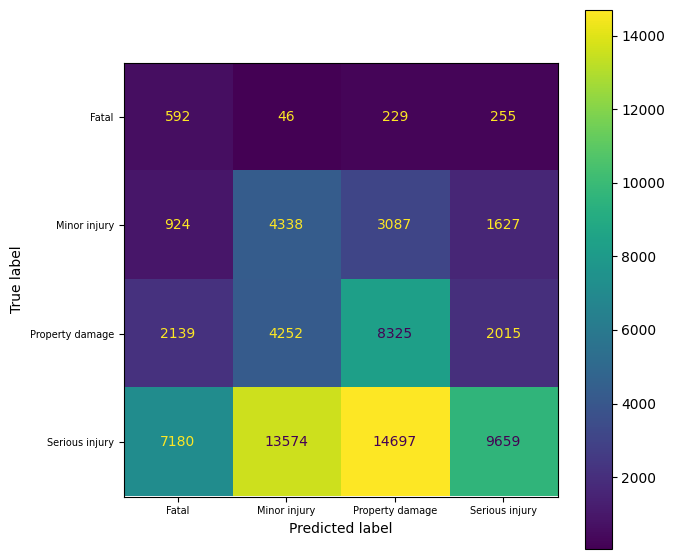

In [15]:
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=42)
param_grid = {
    'xgbclassifier__n_estimators': [100]
}
grid_search = GridSearchCV(pipeline_smote, param_grid, cv=rskf, scoring='accuracy', n_jobs=-1, verbose=0)
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)
print("-------------------------------------------------------------")
print("Evaluation")
y_pred = grid_search.predict(X_test)
model_smote = grid_search.best_estimator_
evaluation_class_8(y_test, y_pred)

### Undersampling

Best parameters: {'xgbclassifier__n_estimators': 100}
Best score:  0.2653159901319347
-------------------------------------------------------------
Evaluation
Accuracy:  0.2617255514882299
Precision:  0.5146475260964494
Recall:  0.2617255514882299
F1-Score:  0.2710245345780647
--------------------------------------------
                 precision    recall  f1-score   support

          Fatal       0.05      0.67      0.09      1122
   Minor injury       0.19      0.43      0.26      9976
Property damage       0.31      0.44      0.36     16731
 Serious injury       0.67      0.15      0.24     45110

       accuracy                           0.26     72939
      macro avg       0.30      0.42      0.24     72939
   weighted avg       0.51      0.26      0.27     72939



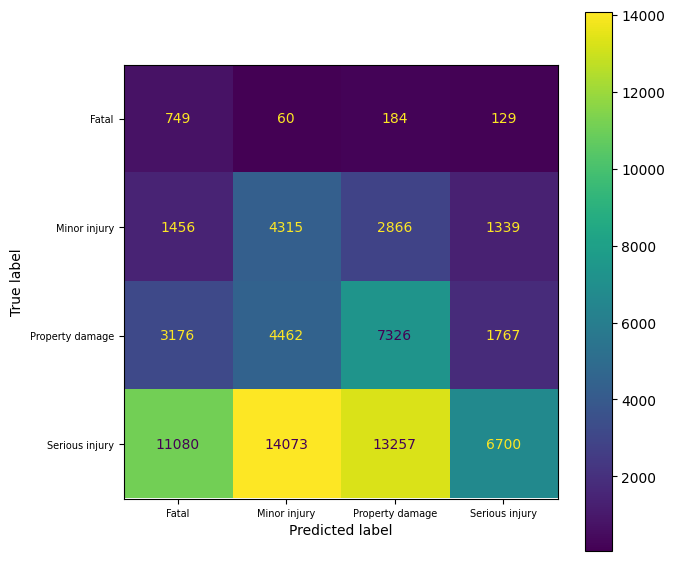

In [16]:
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=42)
param_grid = {
    'xgbclassifier__n_estimators': [100]
}
grid_search = GridSearchCV(pipeline_under, param_grid, cv=rskf, scoring='accuracy', n_jobs=-1, verbose=0)
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)
print("-------------------------------------------------------------")
print("Evaluation")
y_pred = grid_search.predict(X_test)
model_under = grid_search.best_estimator_
evaluation_class_8(y_test, y_pred)

### SMOTEENN

Best parameters: {'xgbclassifier__n_estimators': 100}
Best score:  0.6034782547632355
-------------------------------------------------------------
Evaluation
Average training score:  0.6066936240779868
Average validation score:  0.6034782547632355
Accuracy:  0.611226693352997
Precision:  0.49677564467506424
Recall:  0.611226693352997
F1-Score:  0.4875780573748144
--------------------------------------------
                 precision    recall  f1-score   support

          Fatal       0.14      0.04      0.07      1166
   Minor injury       0.19      0.00      0.01     10409
Property damage       0.37      0.04      0.08     17442
 Serious injury       0.62      0.97      0.76     46927

       accuracy                           0.61     75944
      macro avg       0.33      0.27      0.23     75944
   weighted avg       0.50      0.61      0.49     75944



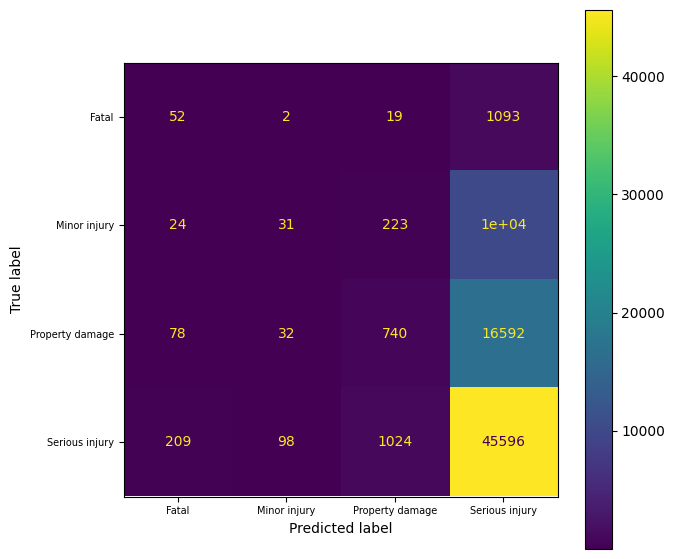

In [9]:
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=42)
param_grid = {
    'xgbclassifier__n_estimators': [100]
}
grid_search = GridSearchCV(pipeline_smoteen, param_grid, cv=rskf, scoring='accuracy', n_jobs=-1, verbose=0, return_train_score=True)
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)
print("-------------------------------------------------------------")
print("Evaluation")
y_pred = grid_search.predict(X_test)
model_smoteenn = grid_search.best_estimator_
cv_results = grid_search.cv_results_
train_scores = cv_results['mean_train_score']
validation_scores = cv_results['mean_test_score']
print("Average training score: ", train_scores.mean())
print("Average validation score: ", validation_scores.mean())
evaluation_class_8(y_test, y_pred)

### Tomek

Best parameters: {'xgbclassifier__n_estimators': 100}
Best score:  0.39235452355178746
-------------------------------------------------------------
Evaluation
Accuracy:  0.38636394795651163
Precision:  0.5289035456939112
Recall:  0.38636394795651163
F1-Score:  0.4189771858230191
--------------------------------------------
                 precision    recall  f1-score   support

          Fatal       0.06      0.40      0.11      1122
   Minor injury       0.20      0.39      0.26      9976
Property damage       0.33      0.44      0.38     16731
 Serious injury       0.69      0.36      0.48     45110

       accuracy                           0.39     72939
      macro avg       0.32      0.40      0.31     72939
   weighted avg       0.53      0.39      0.42     72939



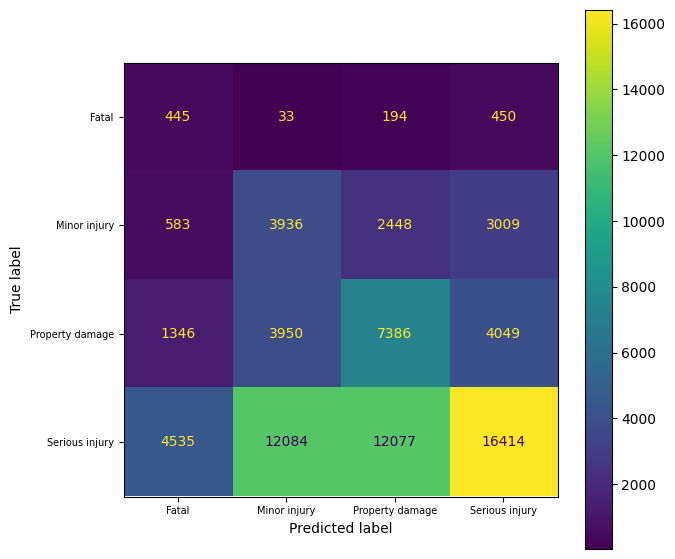

In [43]:
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=42)
param_grid = {
    'xgbclassifier__n_estimators': [100]
}
grid_search = GridSearchCV(pipeline_tomek, param_grid, cv=rskf, scoring='accuracy', n_jobs=-1, verbose=0)
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)
print("-------------------------------------------------------------")
print("Evaluation")
y_pred = grid_search.predict(X_test)
model_smote = grid_search.best_estimator_
evaluation_class_8(y_test, y_pred)